In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고창 무시
import warnings
warnings.filterwarnings(action='ignore')

# matplotlib 한글 폰트 오류 해결
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='appleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system.... sorry.....')
    
# 랜덤 시드 생성
np.random.seed(42)

### 데이터 불러오기
- 1) 원본데이터
- 2) 교통량통합 데이터

In [114]:
data = pd.read_csv('실전db.csv',encoding='ansi')
trans = pd.read_csv('교통량통합.csv',encoding='ansi')

## --------------------------------------------------Feature Engineering----------------------------------------------------

### 'DATE' 컬럼 datetime 변환 후, 교통량통합 데이터와 날짜를 key로 결합

In [115]:
data['DATE']=pd.to_datetime(data['DATE'])
trans['DATE'] = pd.to_datetime(trans['DATE'])

ndata = pd.merge(data,trans, how='left', left_on='DATE', right_on='DATE')

### '교통량합계' : MinMax Scaling (작은 숫자로 변환)
### 'D_TYPE', 'GOODS_TYPE', 'AD1' : Label Encoding (범주형을 숫자형으로 변환)

In [116]:
from sklearn import preprocessing

ndata[['교통량합계']] = preprocessing.MinMaxScaler().fit(ndata[['교통량합계']]).transform(ndata[['교통량합계']])

le = preprocessing.LabelEncoder()

ndata['D_TYPE'] = le.fit_transform(ndata['D_TYPE'])
ndata['GOODS_TYPE'] = le.fit_transform(ndata['GOODS_TYPE'])
ndata['AD1'] = le.fit_transform(ndata['AD1'])

### 유저가 몇번 결재했는지 알려주는 '결제건수' 컬럼 생성 (우량고객 관리 차원)

In [117]:
u_ndata = ndata['USER_ID'].value_counts().to_frame()
u_ndata.reset_index(inplace = True)
u_ndata.columns = ['USER_ID','결제건수']
ndata = pd.merge(ndata, u_ndata, how='left', left_on='USER_ID', right_on='USER_ID')

### '월', '일', '요일' 컬럼 생성
* 요일 : {월:0, 화:1, 수:2, 목:3, 금:4, 토:5, 일:6}

In [118]:
ndata['Month'] = [k for k in ndata['DATE'].dt.month]
ndata['Day'] = [k for k in ndata['DATE'].dt.day]
ndata['dayofweek'] = [k for k in ndata['DATE'].dt.dayofweek]

### 'holiday' 컬럼 생성 (구매량 적은 일요일 + 공휴일)

# 2020년 holiday 지정
import pandas as pd
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday

class Calendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Year', month=1, day=1),
        Holiday('KR_New Year1', month=1, day=24),
        Holiday('KR_New Year2', month=1, day=25),
        Holiday('KR_New Year3', month=1, day=26),
        Holiday('3.1', month=3, day=1),
        Holiday('Buddha Day', month=4, day=30),
        Holiday('Memorial Day', month=6, day=6),
        Holiday('Liberation Day', month=8, day=15),
        Holiday('KR_Thanksgiving1', month=9, day=30),
        Holiday('KR_Thanksgiving2', month=10, day=1),
        Holiday('KR_Thanksgiving3', month=10, day=2),
        Holiday('National Foundation Day', month=10, day=3),
        Holiday('Hangul Day', month=10, day=9),
        Holiday('Christmas', month=12, day=25)
    ]
dr = pd.date_range(start='2020-01-01', end='2020-12-31')
cal = Calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())
ndata['Holiday'] = ndata['DATE'].isin(holidays)

# 일요일도 holiday로
for i in range(len(ndata)):
    if ndata['Day'][i] == 6:
        ndata['Holiday'][i] = True

### 'Weekend_indi' 컬럼 생성 (구매량 많은 금요일+토요일)

ndata['Weekend_indi'] = 0
ndata['EveryDay'] = ndata.loc[ndata['Day'].isin([4,5]), 'Weekend_indi'] =1

### 불필요한 컬럼 삭제

In [119]:
ndata.drop(['USER_ID','JOIN_DATE','STORE_ID'],axis=1,inplace=True)

## ---------------------------------------------------train, test data 분리-----------------------------------------------------

### 학습(1-9월)과 테스트(10-12월) 데이터 나누기

In [120]:
# 날짜로 자르기 위해 'DATE'를 인덱스로 설정
ndata.set_index('DATE',inplace=True)

# 데이터 분리
train = ndata.loc[:'2020-09-30']
test = ndata.loc['2020-10-01':]

# 인덱스 리셋 후 'DATE' 컬럼 삭제
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

### X(독립변수)와 Y(종속변수)로 분리

In [121]:
train_X = train.drop('COUNT',axis=1)
train_y = train[['COUNT']]

test_X = test.drop('COUNT',axis=1)
test_y = test[['COUNT']]

In [122]:
display(train_X, test_X)

,D_TYPE,GOODS_TYPE,AD1,교통량합계,결제건수,Month,Day,dayofweek
0,0,0,40,0.361192,1,1,1,2
1,1,0,50,0.361192,2,1,1,2
2,1,0,64,0.361192,3,1,1,2
3,1,2,53,0.361192,30,1,1,2
4,0,2,52,0.361192,3,1,1,2
...,...,...,...,...,...,...,...,...
623574,1,1,40,0.316042,4,9,30,2
623575,0,1,53,0.316042,1,9,30,2
623576,0,1,4,0.316042,1,9,30,2
623577,1,0,52,0.316042,1,9,30,2


,D_TYPE,GOODS_TYPE,AD1,교통량합계,결제건수,Month,Day,dayofweek
0,0,0,52,0.264088,1,10,1,3
1,1,3,50,0.264088,2,10,1,3
2,1,0,52,0.264088,2,10,1,3
3,1,0,22,0.264088,10,10,1,3
4,0,0,65,0.264088,2,10,1,3
...,...,...,...,...,...,...,...,...
255687,1,1,40,0.563915,1,12,31,3
255688,1,1,19,0.563915,1,12,31,3
255689,0,1,52,0.563915,1,12,31,3
255690,1,1,50,0.563915,1,12,31,3


## ------------------------------------------------------------모델링--------------------------------------------------------------

### 랜덤포레스트 모델링

In [108]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

rfr = RandomForestRegressor()
    
rfr.fit(train_X, train_y)
    
y_pred = rfr.predict(test_X)

MSE = mean_squared_error(test_y, y_pred)
MAE = mean_absolute_error(test_y, y_pred)
print('MSE :', MSE)
print('MAE :', MAE)

MSE : 0.09719544020119382
MAE : 0.0536836780882514


### LightGBM 모델링

!pip install lightgbm

In [123]:
from lightgbm import LGBMRegressor

lgbr = LGBMRegressor(n_estimators=400) # 트리 수 지정

lgbr.fit(train_X, train_y)

y_pred2 = lgbr.predict(test_X)

MSE = mean_squared_error(test_y, y_pred2)
MAE = mean_absolute_error(test_y, y_pred2)
print('MSE :', MSE)
print('MAE :', MAE)

MSE : 0.09139467880723452
MAE : 0.046587546374889856


### 변수 중요도 시각화

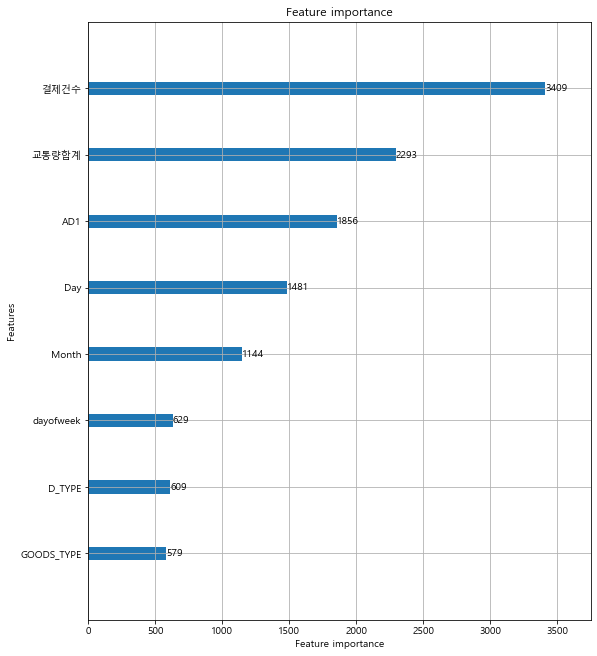

In [124]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(9,11))
plot_importance(lgbr, ax=ax)
plt.savefig('변수의 중요도.png')

### 예측값과 원래 값 비교

In [112]:
comparison = pd.DataFrame({'prediction': y_pred,
                          'ground_truth' : test_y.values.ravel()}) 
comparison
comparison.to_csv('비교.csv',encoding='ansi')